<h1>Forecast Project</h1>

<h2>Database</h2>

<b>Import packages for DB</b>

In [121]:
import yfinance as yfin
import sqlite3 as sql
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

<h3>YFianance API</h3>
<p>Function using the yfinance API to get all market data</p>

<b>Tickers</b>

In [122]:
#array with all the studied currencies (yahoo finance currency names)
currencies = ["BTC-USD","ETH-USD"] 

In [123]:
def getMetaData(s : str) -> dict :
    """Get the meta information for a Ticker (currency)
    
    Args : 
        s (str) : name of the Ticker
        
    Return : 
        dict : return all the  meta information of the Ticker, the dict is the following : 
                - symbol : str ~> name online (yahoo finance) of the stock (is also the ticker name used by the yfinance API)
                - instrumentType : str ~> type of stock, can be a cryptocurrency ,  a stock ...
                - regularMarketTime int : ~> date when those informatation has been gathered in epoch/unix time 
                - gmtoffset int : ~> number of second of offset between the stock's market timezome and the gtm timzome
                - timezone str : ~> name of the stock's market timezone
            other var a disponnible but not used here (see yfinance documentation)
    """    
    ticker = yfin.Ticker(s)
    ticker.history()
    meta = ticker.history_metadata
    return meta
 
def getHistoryData(s : str) -> dict :
    """Get all the information since the creation of the Ticker (currency)
    
    Args : 
        s (str) : name of the Ticker
        
    Return : 
        dict : return all the  information of the Ticker since creation, the dict contaign the following information : {Date,Open,Hight,Low,Close,Volume}
    """
    ticker = yfin.Ticker(s)
    data = ticker.history("max", interval = '1d')
    data['Date'] = data.index
    data = data[["Date", "Open", "High", "Low", "Close", "Volume"]]
    data.reset_index(drop=True, inplace=True)
    return data

def getPeriodData(s : str , period : str) -> dict :
    """Get the information of the Ticker for a certain period
    
    Args : 
        s (str) : name of the Ticker
        period (str) : duration of the period , the information period get are ending to the current day and start a period back can take value like {1d , 5d , 1m , 1y , ...}
    
    Return : 
        dict : return all the  information of the Ticker for the period, the dict contaign the following information : {Date,Open,Hight,Low,Close,Volume}
    """
    ticker = yfin.Ticker(s)
    data = ticker.history(period = period ,interval = '1d')
    data['Date'] = data.index
    data = data[["Date", "Open", "High","Low", "Close", "Volume"]]
    data.reset_index(drop=True, inplace=True)
    return data

<h3>DataBase Gestion</h3>

<h4>Currencies_Metadata table</h4>
<p>This table contaign all the usefull metadata of each currencies fetched. It contaigns : </p>
<ul><li><b>currencyName</b> ~> name online (yahoo finance) of the stock (is also the ticker name used by the yfinance API)</li>
<li><b>instrumentType</b> ~> type of stock, can be a cryptocurrency ,  a stock ...</li>
<li><b>regularMarketTime</b> ~> date when those informatation has been gathered in epoch/unix time </li>
<li><b>gtmOffset</b> ~> number of second of offset between the stock's market timezome and the gtm timezome</li>
<li><b>timezone</b> ~> name of the stock's market timezone</li></ul>
It is possible to 
<ul><li>Create / Fill <b>table</b></li>
<li>Insert / Get / Modify / Delete / Print <b>table elements</b></li></ul>

In [124]:
def createCurrencyMetadataTable():
    """Create a new currency table """
    db = sql.connect("mydatabase.db")
    c = db.cursor()

    requestCreate = '''CREATE TABLE IF NOT EXISTS CURRENCIES_METADATA (
        [currencyId] INTEGER PRIMARY KEY AUTOINCREMENT,
        [currencyName] TEXT, 
        [instrumentType] TEXT,
        [regularMarketTime] INTEGER,
        [gtmOffset] INTEGER,
        [timezone] TEXT
        )'''
    #currencyName : str ~> name online (yahoo finance) of the stock (is also the ticker name used by the yfinance API)
    #instrumentType : str ~> type of stock, can be a cryptocurrency ,  a stock ...
    #regularMarketTime int : ~> date when those informatation has been gathered in epoch/unix time 
    #gtmOffset int : ~> number of second of offset between the stock's market timezome and the gtm timzome
    #timezone str : ~> name of the stock's market timezone
    c.execute(requestCreate) # create a new currency table
    db.commit()

def getCurrencyMetadataElement(currencyId : int) -> dict :
    """Get an element of the currency table by its id

    Args:
        currencyId (int): id of the currency in the table

    Returns:
        dict: return the element as a dict with all metadata of a currency
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    request = f'''SELECT * FROM CURRENCIES_METADATA WHERE currencyId='{currencyId}' '''
    c.execute(request)
    return list(c.fetchone())

def getIdByNameCurrencyMetadata(currencyName: str) -> int :
    """Get an element id of the currency table by its name

    Args:
        currencyName (str): name of the stock

    Returns:
        int: return the element id
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    request = f'''SELECT currencyId FROM CURRENCIES_METADATA WHERE currencyName='{currencyName}' '''
    c.execute(request)
    return c.fetchone()

def printCurrencyMetadataElement(currencyId : int):
    """Print an element of the currency table by its id 

    Args:
        currencyId (int): id of the currency in the table 
    """
    metaData = getCurrencyMetadataElement(currencyId)
    header = f"-------- MetaData for {metaData[1]} --------"
    nHeader = len(header)
    print(header)
    print(f"\nName : {metaData[1]}")
    print(f"ID : {metaData[0]}")
    print(f"instrumentType : {metaData[2]}")
    print(f"regularMarketTime : {metaData[3]}")
    print(f"gtmOffset : {metaData[4]}")
    print(f"timezone : {metaData[5]}")
    footer = "\n"
    for i in range(nHeader): footer += "-"
    print(footer)

def insertCurrencyMetadataElement(currency : str):
    """Insert a new  element in the currency table

    Args:
        currency (str): name of the currency to fetch its metadata with the yFinance API
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    metaData = getMetaData(currency)
    request = f'''INSERT INTO CURRENCIES_METADATA (currencyName,instrumentType,regularMarketTime,gtmOffset,timezone)
        VALUES (
        '{metaData['symbol']}',
        '{metaData['instrumentType']}',
        '{metaData['regularMarketTime']}',
        {metaData['gmtoffset']},
        '{metaData['timezone']}')'''
    c.execute(request)
    db.commit()

def modifyCurrencyMetadataElement(currencyId : int, newMetaData : dict):
    """Modify an element in the currency table, the element to modify must be enteriely rewrite 

    Args:
        currencyId (int): id of the currency to modify in the currency table
        newMetaData (dict): dictionnary contaigning all the information of the currency even the ones not changed
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    #All the information MUST be given in the newMetaData dict even the id and the ones not changed
    request = f'''UPDATE CURRENCIES_METADATA 
        SET 
        currencyId={newMetaData['currencyId']},
        currencyName='{newMetaData['symbol']}', 
        instrumentType='{newMetaData['instrumentType']}', 
        regularMarketTime='{newMetaData['regularMarketTime']}',
        gtmOffset={newMetaData['gtmOffset']},
        timezone='{newMetaData['timezone']}' 
        WHERE currencyId = {currencyId}'''
    c.execute(request)
    db.commit()

def deleteCurrencyMetadataElement(currencyId : int):
    """Delete an element from the currency table

    Args:
        currencyId (int): id of the currency to delete from the currency table
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    request = f'''DELETE FROM CURRENCIES_METADATA
        WHERE currencyId = {currencyId}'''
    c.execute(request)
    db.commit()


<h4>Others</h4>
<p>Usefull an necessary function for next parts </p>

In [125]:
def cleanNameForSQL(s : str) -> str:
	"""Return a new string that dont contaign special char to use it as sql table name

	Args:
		s (str): string where to remove special char 

	Returns:
		str: new string without special char nor spaces 
	"""
	for char in ['-','.','^',' ']:
		s = s.replace(char,"")
	return s

<h4>Market Tables</h4>
There is one market table for each currency fetched. It contaigns :
<ul><li><b>Date</b> ~> date of the information present</li>
<li><b>Open</b> ~> value of the stock when the market open</li>
<li><b>High</b> ~> highest value reach by the stock during the market time</li> 
<li><b>Low</b> ~> lowest value reach by the stock during the market time</li>
<li><b>Close</b> ~> value of the stock when the market close </li>
<li><b>Volume</b> ~> total of stock sells during the market time</li>
</ul>
It is possible to 
<ul><li>Create / Fill  <b>table</b></li>
<li>Insert / Get / Print <b>table elements</b></li></ul>

In [126]:
def createCurrencyMarketTable(currencyName : str):
    """Create a new table if it dont alredy exist to contaign all the market infomation of a currency

    Args:
        currencyName (str): name of the currency for which a new table is created
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    tableName = cleanNameForSQL(currencyName)
    #each lign in the table represent a new day and contaign :
    #   Date : date ~> date of the information present
    #   Open : float ~> value of the stock when the market open
    #   High : float ~> highest value reach by the stock during the market time 
    #   Low : float ~> lowest value reach by the stock during the market time
    #   Close : float ~> value of the stock when the market close 
    #   Volume : float ~> total of stock sells during the market time 
    createNewCurrencyTable = f'''CREATE TABLE IF NOT EXISTS {tableName}_MARKET 
    ([Id] INTEGER PRIMARY KEY AUTOINCREMENT,
    [Date] TEXT,
    [Open] NUMBER,
    [High] NUMBER,
    [Low] NUMBER,
    [Close] NUMBER,
    [Volume] INTEGER);'''
    c.execute(createNewCurrencyTable)
    db.commit()

def fillCurrencyMarketTable(currency : str , period : str = None):
    """Fill a currency market table with its information

    Args:
        currency (str): yahoo finance name of the currency , used to get the information with the API
        period (str, optional): default value is none : all the information since create are fetched, can be defined to limit the period (for value value autorized see yfinance doc). Defaults to None.
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()

    tableName = cleanNameForSQL(currency)
    requestTemplate = f'''INSERT INTO {tableName}_MARKET (Date,Open,High,Low,Close,Volume)
        VALUES  '''

    #verify if @period has been enter as parameter
    if period : data = getPeriodData(currency , period)  #if yes get only period data
    else : data = getHistoryData(currency) # else get all data since creation

    #for each lign in data fetched, the request add them in the table
    for i in range(len(data)):
        line = data.iloc[i]
        #round(line[2:5],13) #all number are rounded to the 13th decimal to avoid some float type python issues  
        request =requestTemplate + f'''('{line['Date']}',
        {line['Open']},
        {line['High']},
        {line['Low']},
        {line['Close']},
        {line['Volume']});'''

        c.execute(request)
    db.commit()

def getCurrencyMarketElementById(currency : str , elementId : int ) -> dict :
    """Get an element from a currency market table by its id 

    Args:
        currency (str): yahoo finance name of the currency , used to get the information with the API
        elementId (int): id of the element to get 

    Returns:
        dict: element of the table which id is elementId 
    """
    tableName = cleanNameForSQL(currency)
    request = f'''SELECT * FROM {tableName}_MARKET WHERE Id = {elementId}  '''

    db = sql.connect("mydatabase.db")
    c = db.cursor()
    c.execute(request)
    return c.fetchone()

def getAllCurrencyMarketElement(currency : str  ) -> pd.DataFrame :
    """Get all elements from a currency market table by its id 

    Args:
        currency (str): yahoo finance name of the currency , used to get the information with the API

    Returns:
        list: list of all elements of the table 
    """
    tableName = cleanNameForSQL(currency)
    request = f'''SELECT Date,Open,High,Low,Close,Volume FROM {tableName}_MARKET'''

    db = sql.connect("mydatabase.db")
    c = db.cursor()
    c.execute(request)
    res =  pd.DataFrame(c.fetchall(),columns=['Date','Open','High','Low','Close','Volume'])
    # for i in range(len(res)):
    #     res[i] = list(res[i])
    return res

def getCloseCurrencyMarketElement(currency : str  ) -> list :
    """Get  close elements from a currency market table by its id 

    Args:
        currency (str): yahoo finance name of the currency , used to get the information with the API

    Returns:
        list: list of all elements of the table 
    """
    tableName = cleanNameForSQL(currency)
    request = f'''SELECT Close FROM {tableName}_MARKET'''

    db = sql.connect("mydatabase.db")
    c = db.cursor()
    c.execute(request)
    res =  c.fetchall()
    for i in range(len(res)):
        res[i] = list(res[i])[0]
    return res

def getDateCurrencyMarketElement(currency : str  ) -> list :
    """Get date elements from a currency market table by its id 

    Args:
        currency (str): yahoo finance name of the currency , used to get the information with the API

    Returns:
        list: list of all elements of the table 
    """
    tableName = cleanNameForSQL(currency)
    request = f'''SELECT Date FROM {tableName}_MARKET'''

    db = sql.connect("mydatabase.db")
    c = db.cursor()
    c.execute(request)
    res =  c.fetchall()
    for i in range(len(res)):
        res[i] = datetime.datetime.strptime(list(res[i])[0][2:10],"%y-%m-%d").date()
    return res

def insertCurrencyMarketElement(currency : str, element : dict):
    """Insert a new currency market element in the corresponding table

    Args:
        currency (str): yahoo finance name of the currency
        element (dict): new element to add in the table , this dict must contaign definition for {Date,Open,Hight,Low,Close,Volume}
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    tableName = cleanNameForSQL(currency)
    request = f'''INSERT INTO {tableName}_MARKET (Date,Open,High,Low,Close,Volume) VALUES 
    ('{element['Date']}',{element['Open']},{element['High']},{element['Low']},{element['Close']},{element['Volume']})'''
    c .execute(request)
    db.commit()

def printCurrencyMarketElement(currency : str , currencyId : int):
    """Print an element of the currency table by its id 

    Args:
        currency (str): yahoo finance name of the currency  
        currencyId (int): id of the currency in the table 
    """
    data = getCurrencyMarketElementById(currency , currencyId)
    header = f"-------- Value for {currency} ID°{currencyId} --------\n"
    nHeader = len(header)
    print(header)
    print(f"Date : {data[1]}")
    print(f"Open : {data[2]}")
    print(f"High : {data[3]}")
    print(f"Low : {data[4]}")
    print(f"Close : {data[5]}")
    print(f"Volume : {data[6]}")
    footer = "\n"
    for i in range(nHeader): footer += "-"
    print(footer)

#No Modify or Delete function debause they currently don't seem usefull 

<h4>Forecast Table</h4>
There is one forcast table for each currency fetched. It contaigns :
<ul><li><b>Date</b> ~> date of the forecast</li>
<li><b>Open</b> ~> forecast value of the stock when the market open</li>
<li><b>High</b> ~> forecast highest value reach by the stock during the market time</li> 
<li><b>Low</b> ~> forecast lowest value reach by the stock during the market time</li>
<li><b>Close</b> ~> forecast value of the stock when the market close </li>
</ul>
It is possible to :
<ul><li>Create / Fill  <b>table</b></li>
<li>Insert / Get / Modify / Delete / Print <b>table elements</b></li></ul>

In [153]:
def createCurrencyForecastTable(currencyName : str):
    """Create a new table if it dont alredy exist to contaign market forecast prevision of a currency

    Args:
        currencyName (str): name of the currency for which a new table is created 
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    tableName = cleanNameForSQL(currencyName)
    #each lign in the table represent a new day and contaign :
    #   Date : date ~> forecast date of the information present
    #   Open : float ~> forecast value of the stock when the market open
    #   High : float ~> forecast highest value reach by the stock during the market time 
    #   Low : float ~> forecast lowest value reach by the stock during the market time
    #   Close : float ~> forecast value of the stock when the market close 
    createNewCurrencyForecastTable = f'''CREATE TABLE IF NOT EXISTS {tableName}_FORECAST 
    ([Id] INTEGER PRIMARY KEY AUTOINCREMENT,
    [Date] TEXT,
    [Open] NUMBER,
    [High] NUMBER,
    [Low] NUMBER,
    [Close] NUMBER)'''
    c.execute(createNewCurrencyForecastTable)
    db.commit()

def getCurrencyForecastElementById(currency : str , elementId : int ) -> dict :
    """Get an from a currency forecast table by its id 

    Args:
        currency (str): yahoo finance name of the currency , used to get the information with the API
        elementId (int): id of the element to get 

    Returns:
        dict: element of the table which id is elementId 
    """
    tableName = cleanNameForSQL(currency)
    request = f'''SELECT * FROM {tableName}_FORECAST WHERE Id = {elementId}  '''
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    c.execute(request)
    return c.fetchone()

def insertCurrencyForecastElement(currency : str, element : dict):
    """Insert a new currency forecast element in the corresponding table 

    Args:
        currency (str): yahoo finance name of the currency
        element (dict): new element to add in the table , this dict must contaign definition for {Date,Open,Hight,Low,Close,Volume}
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    tableName = cleanNameForSQL(currency)
    request = f'''INSERT INTO {tableName}_FORECAST (Date,Close) VALUES 
    ('{element['Date']}',{element['Close']})'''
    c .execute(request)
    db.commit()

def modifyCurrencyForecastElement(currency : str , elementId : int, newElement : dict):
    """Modify an element in the currency forecast table, the element to modify must be enteriely rewrite

    Args:
        currency (str): id of the currency to modify in the currency table
        elementId (int): id of the currency to modify in the currency table
        newElement (dict): dictionnary contaigning all the information of the currency even the ones not changed
    """
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    #All the information MUST be given in the newMetaData dict even the id and the ones not changed
    tableName = cleanNameForSQL(currency)
    request = f'''UPDATE {tableName}_FORECAST 
        SET 
        Date={newElement['Id']},
        Close={newElement['Close']},
        WHERE Id = {elementId}'''
    c.execute(request)
    db.commit()

def deleteCurrencyForecastElement(currency : str , currencyId : int):
    """Delete an element from the currency forecast table

    Args:
        currency (str): yfinance currency name 
        currencyId (int): id of the currency to delete from the currency table
    """
    tableName = cleanNameForSQL(currency)
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    request = f'''DELETE FROM {tableName}_FORECAST 
        WHERE currencyId = {currencyId}'''
    c.execute(request)
    print(c.execute(request))
    db.commit()

def printCurrencyForecastElement(currency : str , currencyId : int):
    """Print an element of the currency forecast table by its id 

    Args:
        currency (str): yahoo finance name of the currency  
        currencyId (int): id of the currency in the table 
    """
    data = getCurrencyForecastElementById(currency , currencyId)
    header = f"-------- Forecast for {currency} ID°{currencyId} --------\n"
    nHeader = len(header)
    print(header)
    print(f"Date : {data[1]}")
    print(f"Close : {data[5]}")
    footer = "\n"
    for i in range(nHeader): footer += "-"
    print(footer)


<h4>Initialization DB Function</h4>
<p>Scipt to initialize the database</p>

In [128]:
def setDb(currencies : list):
    """Initialize the database

    Args:
        currencies (list): list of currencies to add during the db initailization
    """
    createCurrencyMetadataTable()
    for currency in currencies:
        insertCurrencyMetadataElement(currency)
        createCurrencyMarketTable(currency)
        fillCurrencyMarketTable(currency,period = "1y")
        createCurrencyForecastTable(currency)

In [130]:
import os
#create db
try:
    os.remove("mydatabase.db") #delete database if it exixts 
except:
    pass # if it not exists just go next
setDb(currencies)

<h3>Database Test</h3>

In [ ]:
def GeneralDatabaseTest():
        #Test if db exists
    print("--- Database General Test ---")
    if os.path.exists("./mydatabase.db") : 
        print("Test 1 passed : Database exist")
    else : 
        print("Test failled : No database named `mydatabase.db` created")
        return 0
    return 1

def CurrenciesMetadatGeneralTest():
    """Assert the structure of the CURRENCIES_METADATA is good"""
    print("\n--- CURRENCIES_METADATA General Test ---")
    #Test if CURRENCIES_METADATA structure is good
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    request ='''SELECT * FROM CURRENCIES_METADATA'''
    c.execute(request)
    elem = c.fetchone()
    #First test number of element
    if len(elem) == 6 : 
        print("Test 2 passed : Number of element in table good")
    else : 
        print("Test failed : The number of element in the CURRENCIES_METADATA table isn't correct")
        return 0
    #Then test element types
    types = (int , str , str , str , int , str)
    testResult = True
    for i in range(len(elem)):
        if type(elem[i]) != types[i]:
            testResult = False
            print(f'Test failed : the type of the {i} element doesn\'t correspond, it\'s a {type(elem[i])} but should be a {types[i]}')
            return 0
    if testResult: print("Test 3 passed : Element types good")
    return 1

def CurrenciesMetadatGetTest():
    """Assert the first element of the CURRENCIES_METADATA table correspond to the `BTC-USD` one"""
    print("\n--- CURRENCIES_METADATA GET Method Test ---")
    btcusd = (1 , "BTC-USD" , "CRYPTOCURRENCY" , -1 , 0 , "UTC")
    resget = getCurrencyMetadataElement(1)
    t = np.column_stack((resget , btcusd))
    for i , j in t:
        if not i == j and j == -1:
            print(f'Test failed : the element get by the method does not correspond to the BTC-USD one the values {i} should be {j}')
            return 0
    print("Test 4 passed : The Element Fetched Correspond")
    return 1

def CurrenciesMetadatInsertTest():
    """Assert the neawly  inserted  element of the CURRENCIES_METADATA table is inserted and correct"""
    print("\n--- CURRENCIES_METADATA INSERT Method Test ---")
    nElem  = len(currencies)
    newElem = (nElem , "newElem" , "CRYPTOCURRENCY" , -1 , 0 , "UTC")
    insertCurrencyMetadataElement("TPA")
    resget = getCurrencyMetadataElement(nElem)
    t = np.column_stack((resget , newElem))
    for i , j in t:
        if not i == j and j == -1:
            print(f'Test failed : the element inserted isn\'t correct : the values {i} should be {j}')
            return 0
    print("Test 5 passed : The Element Is Inserted and is Correct")
    return 1

def TestCurrencyTable():
    """Assert all the CURRENCIES_METADATA table structure and method are functionnal"""
    return CurrenciesMetadatGeneralTest() and CurrenciesMetadatGetTest() and CurrenciesMetadatInsertTest()


In [ ]:
def TestDatabase():
    """Assert all the database is functionnal"""
    if not GeneralDatabaseTest(): 
        print("Tests have Failed")
        return 0
    if not TestCurrencyTable(): 
        print("Tests have Failed")
        return 0

TestDatabase()

--- Database General Test ---
Test 1 passed : Database exist

--- CURRENCIES_METADATA General Test ---
Test 2 passed : Number of element in table good
Test 3 passed : Element types good

--- CURRENCIES_METADATA GET Method Test ---
Test 4 passed : The Element Fetched Correspond

--- CURRENCIES_METADATA INSERT Method Test ---
TPA: No data found for this date range, symbol may be delisted
Test 5 passed : The Element Is Inserted and is Correct


<h2>Forecasting Script (Neural Network Part)</h2>

<h3>Get Stock Data</h3>

In [210]:
from pandas_datareader.data import DataReader 
from datetime import date
import yfinance as yf

##The code bellow can be use to avoid local db acces 
# currencies = ["BTC-USD","ETH-USD","TTE.PA"] 
# start_date = '2021-01-01'
# end_date = str(date.today())

# yf.pdr_override()
# df = DataReader(
#     'BTC-USD',
#     # 'yahoo',
#     start=start_date,
#     end=end_date
# )
# df.head()

# currencies = ["BTC-USD","ETH-USD"] 
#Possible to change the index to change between BTC or ETH
currency = currencies[1]

df = getAllCurrencyMarketElement(currency)
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

df.head()



,Open,High,Low,Close,Volume
Date,,,,,
2022-04-25 00:00:00+00:00,2922.990234,3018.415527,2804.507080,3009.393555,22332690614
2022-04-26 00:00:00+00:00,3008.946289,3026.415039,2786.253174,2808.298340,19052045399
2022-04-27 00:00:00+00:00,2808.645996,2911.877441,2802.273438,2888.929688,17419284041
2022-04-28 00:00:00+00:00,2888.849854,2973.135010,2861.821533,2936.940918,18443524633
2022-04-29 00:00:00+00:00,2936.776611,2943.445801,2782.435303,2815.601807,18771041399


[]

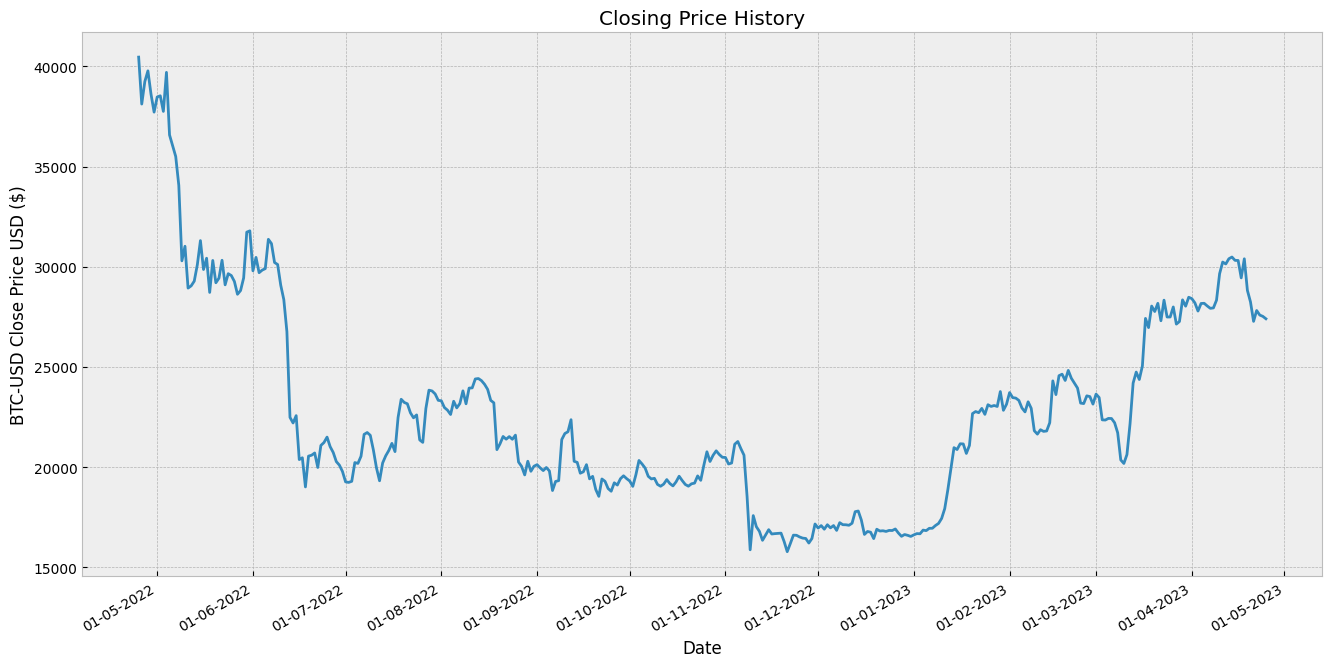

In [185]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.ylabel(f'{currency} Close Price USD ($)')
plt.xlabel('Date')
plt.title('Closing Price History')

#Change datetime tick label frequency
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

plt.plot()

In [197]:
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np

data = df.filter(['Close']).values
training_data_len = math.ceil(0.8*len(data))

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len:]

# train_data = data[:training_data_len]
# test_data = data[training_data_len:]

x_train , y_train = [] , []

<h3>Neural Network</h3>

In [187]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    LSTM
)

TensorFlow version: 2.12.0
Keras version: 2.12.0


<h4>Hyperparameters and other variable definition</h4>

In [198]:
def create_dataset(dataset , lag :int):
    x , y = [] , []
    for i in range(lag, len(dataset)):
        x.append(dataset[i-lag:i,0])
        y.append(dataset[i,0])
    return np.array(x),np.array(y)

In [199]:
lag = 60
x_train , y_train = create_dataset(train_data,lag)
x_test , y_test = create_dataset(test_data,lag)

<h4>Model definition</h4>

In [ ]:
# Create a new sequential model
model = Sequential()

model.add( 
    LSTM(100 , return_sequences=True,
         input_shape = (x_train.shape[1] , 1)
    ))

model.add( 
    LSTM(100 , return_sequences=False 
    ))

model.add(Dense(50))
model.add(Dense(1))

2023-04-25 13:54:51.129338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-25 13:54:51.131183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-25 13:54:51.133198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [200]:
#Compile model
model.compile(optimizer='adam' , loss='mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 126,301
Trainable params: 126,301
Non-trainable params: 0
_________________________________________________________________


<h4>Model Training</h4>

In [201]:
model.fit(x_train , y_train , batch_size=8 , epochs=50 , verbose=1)

Epoch 1/50


2023-04-25 14:45:46.069720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-25 14:45:46.071525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-25 14:45:46.072606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/30 [===============>..............] - ETA: 0s - loss: 9.9054e-04

KeyboardInterrupt: 

In [202]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

train_predictions = scaler.inverse_transform(y_pred_train) 
test_predictions = scaler.inverse_transform(y_pred_test) 

2023-04-25 14:45:52.430751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-25 14:45:52.432252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-25 14:45:52.433681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 27ms/step


<h4>Model Training Results</h4>

/tmp/ipykernel_2359/144579676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Learning'] = train_predictions
/tmp/ipykernel_2359/144579676.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = test_predictions


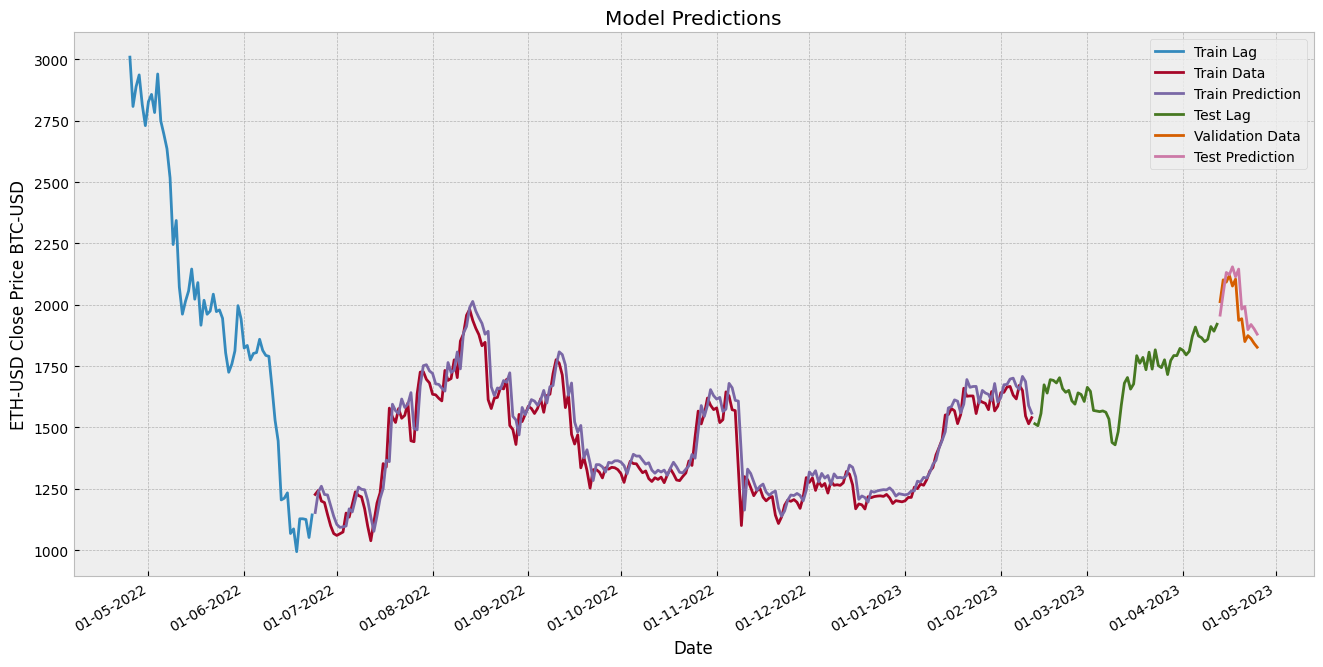

In [203]:
train_lag = df[:60]
train = df[60:training_data_len]
train['Learning'] = train_predictions


test = df[training_data_len:training_data_len+lag]


valid = df[training_data_len+lag:]
valid['Predictions'] = test_predictions

plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date')
plt.ylabel(f'{currency} Close Price BTC-USD')
plt.plot(train_lag['Close'])
plt.plot(train[['Close','Learning']])
plt.plot(test['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train Lag','Train Data','Train Prediction','Test Lag','Validation Data','Test Prediction'])

#Change datetime tick label frequency
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate() 

plt.show()

<h3>Forecasting</h3>

2023-04-25 14:45:57.905954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-25 14:45:57.907642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-25 14:45:57.908956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 3ms/step


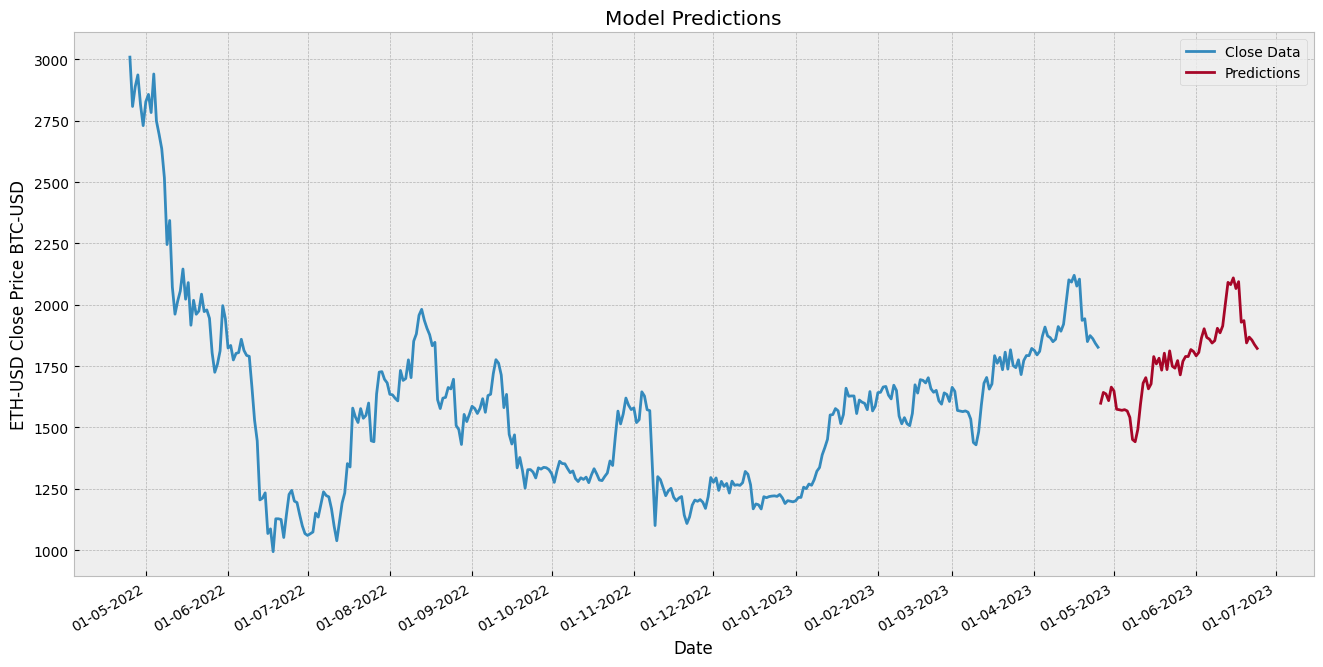

In [204]:


x_predict = scaled_data[-60:]

y_predict = model.predict(x_predict)

predictions = scaler.inverse_transform(y_predict)
predictions = pd.DataFrame(predictions, columns=['Close'])

init_date : np.datetime64 = df.index.values[-1]

predictions['Date'] = init_date + np.timedelta64(1,'D')
for i in range(len(predictions)):
    predictions['Date'].values[i] += np.timedelta64(i,'D')
predictions_display = predictions.set_index('Date')


plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date')
plt.ylabel(f'{currency} Close Price BTC-USD')
plt.plot(df['Close'])
plt.plot(predictions_display['Close'])
plt.legend(['Close Data','Predictions'])


#Change datetime tick label frequency
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate() 

plt.show()

<h4>Add Element in DB</h4>

In [205]:
for index, row in predictions.iterrows():
            insertCurrencyForecastElement(currency,row)

In [209]:
printCurrencyForecastElement(currency,np.random.randint(60))

-------- Forecast for ETH-USD ID°32 --------

Date : 2023-05-27 00:00:00
Close : 1769.6575927734375

---------------------------------------------
